# ***But du Notebook***

## Détecter et caractériser les formes géométriques présentes dans chaque image

Ce notebook utilise la bibliothèque OpenCV pour charger des images,  
et essaie de caractériser les formes géométriques présentes dans chaque image.


### Lecture de la configuration pour obtenir les chemins de base des dossiers de données et d'images.

In [2]:
import configparser
config = configparser.ConfigParser()
config.read('../Rakuten_config2.ini')
def get_RACINE_DOSSIER() :
    return config['DOSSIER']['RACINE_DOSSIER']
def get_RACINE_IMAGES() :
    return config['DOSSIER']['RACINE_IMAGES']
print( get_RACINE_DOSSIER())
print( get_RACINE_IMAGES())

../input/
../data/images/image_train/


### importation de bibliothèques

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import os
import cv2

### Chargement des Données

In [4]:
# lecture des données sources d'entrainement
df_feats=pd.read_csv(get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)
cat=df_target['prdtypecode'].sort_values().unique()
cat
nomenclature=pd.read_csv(get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#### Aperçu des données 

In [5]:
df_feats.head(5)

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [6]:
df_target.head(5)

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705


#### Création de noms d'image et copie du DataFrame :
Ajout d'une colonne nom_image pour nommer les fichiers d'images basés sur imageid et productid,  
puis création d'une copie du DataFrame pour une utilisation future.

In [7]:
df['nom_image']=df.apply(lambda row: "image_" +  str(row['imageid']) 
                                     + "_product_" + str(row['productid']) + ".jpg",axis=1)
print("Nb enreg ", str(df.shape[0]))
df.head(5)
df_img=df.copy()

Nb enreg  84916


#### Chargement des images

    Id                                        designation  \
2    2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
31  31                                X-Men 3 - The Movie   
34  34                              The Lord Or Thé Rings   
40  40  Mini Console De Jeux Double Joueurs 8 Bits Con...   
47  47       Shin Masoukishin Panzer Warfare (Import Jap)   

                                          description   productid     imageid  \
2   PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978   
31                                                NaN    49132716   874730792   
34                                                NaN  4237073471  1324384878   
40  Nom de la marque:NoEnName_Null<br />Affichage ...  4200874030  1316147329   
47                                                NaN     8870838   868167157   

    prdtypecode                                nom_image  
2            50    image_938777978_product_201115110.jpg  
31           40     image_87

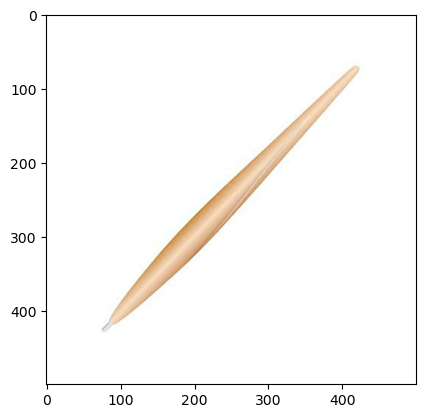

In [8]:
import os
import cv2
import numpy as np

from PIL import Image

# Définir le chemin du dossier contenant les images
#folder_path = "C:\\Users\\MANUADMIN\\python\\DataScience\\Datascientest\\PROJET\\images\\image_train"
folder_path = get_RACINE_IMAGES() 

df_img=df[df['prdtypecode'].isin([40,50,60])]
print(df_img.head())

# Charger les images et les stocker dans un tableau
image_list = []


for filename in df_img['nom_image'][df_img['prdtypecode']==50]:
    #print(os.path.join(folder_path, filename))
    #image = Image.open(os.path.join(folder_path, filename))
    #image.show()
    img = cv2.imread(os.path.join(folder_path, filename))
    if img is not None:
        image_list.append(img)



# Convertir la liste d'images en un tableau numpy
images = np.array(image_list)
print(len(images))
print(images.shape)


# Afficher la première image
image=images[0,:,:,:]
plt.imshow(image)
plt.show()




#### Affichage de plusieurs images 

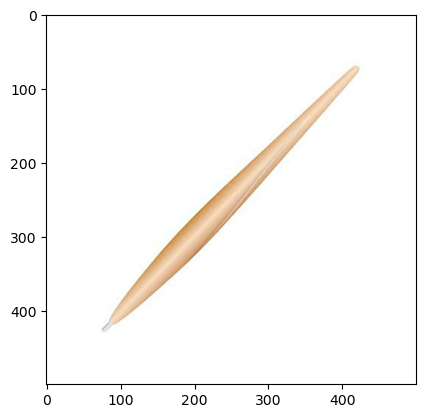

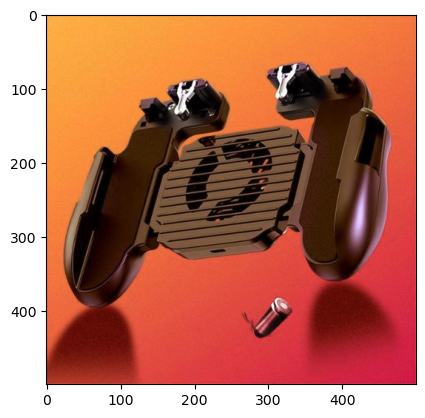

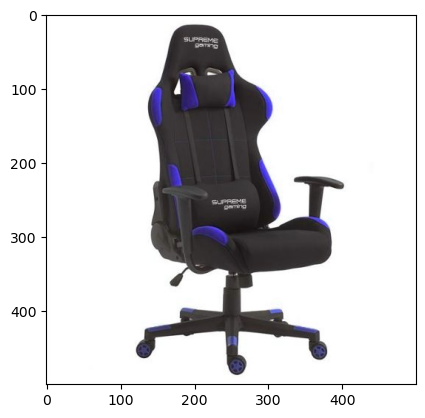

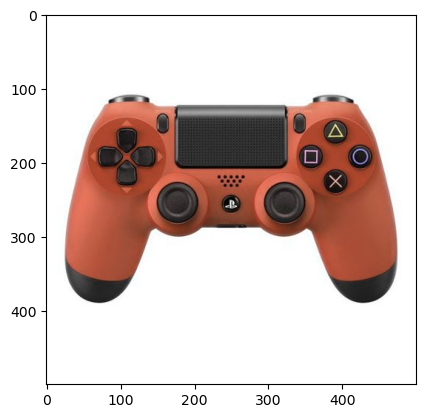

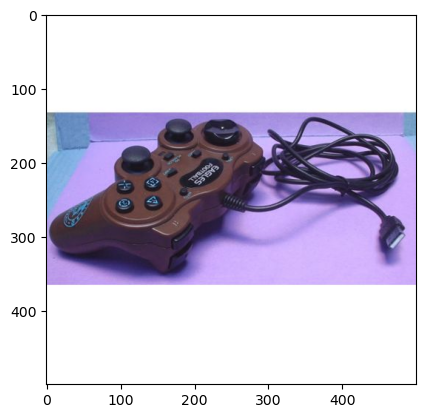

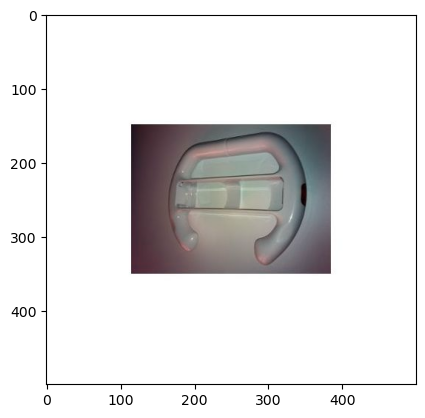

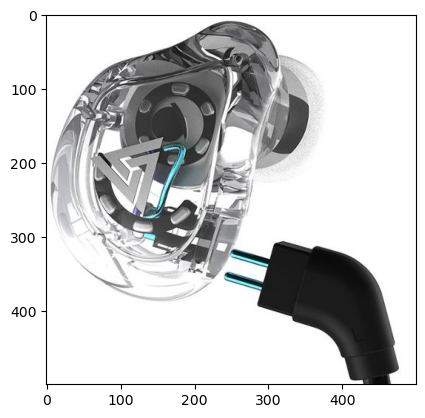

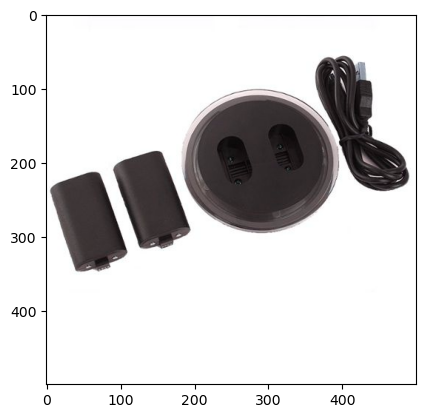

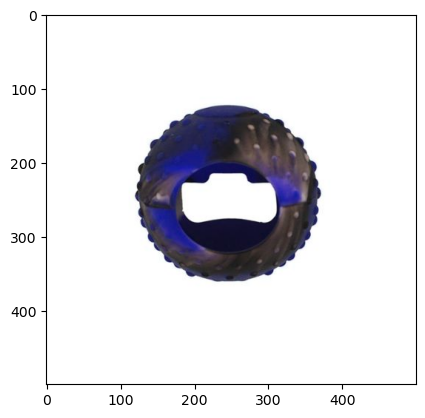

In [9]:
for i in range(9):
    image=images[i,:,:,:]
    plt.imshow(image)
    plt.show()

#### Caractérisation des formes géométriques présentes dans chaque image

**Analyse des Contours :**

- Pour chaque contour détecté, le code calcule l'aire et le périmètre du contour.
- La circularité est calculée pour chaque contour, qui est une mesure de la "rondeur" du contour. Une valeur de circularité proche de 1 indique une forme circulaire parfaite.
- `cv2.approxPolyDP` est utilisé pour approximer le contour avec un polygone dont le nombre de sommets (*corners*) est déterminé. Cela aide à classifier la forme basée sur le nombre de sommets (ex : un triangle a 3 sommets).

**Stockage des Résultats :**

- Les caractéristiques des contours (nombre de sommets et circularité) se traitées.


In [10]:
Dfcontour=pd.DataFrame()
# Définir les classes de formes
classes = {0: 'cercle', 2: 'ligneE', 3: 'triangle', 4: 'rectangle', 5: 'pentagone', 6: 'hexagone'}
for i in range(len(images)):
    image=images[i,:,:,:]
    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Appliquer un filtre pour réduire le bruit de l'image
    gray_blur = cv2.GaussianBlur(gray, (3, 3), 0)
    # Détecter les contours de l'image
    edges = cv2.Canny(gray_blur, 50, 150, apertureSize=3)
    # Extraire les caractéristiques des contours détectés
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shapes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0 :
            circularity = 0
        else :    
            circularity = 4 * np.pi * area / perimeter ** 2
        approx = cv2.approxPolyDP(cnt, 0.01 * perimeter, True)
        corners = len(approx)
        shapes.append((corners, circularity))
        """
        for contour in contours:
            # Approximer le contour
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Classer la forme en fonction du nombre de sommets
            num_vertices = len(approx)
            shape = classes.get(num_vertices, "unknown")
            print("Shape: ", shape)
        """                    
    if len(Dfcontour) == 0 :
        Dfcontour =pd.DataFrame(shapes, columns=['corners','circularity'])    
    else:
        Dfcontour = pd.concat([Dfcontour,pd.DataFrame(shapes, columns=['corners','circularity']) ]
                              ,ignore_index=True,axis=0)
print(Dfcontour.head())    
    

C:\Users\shaky\AppData\Local\Temp\ipykernel_11800\1384081982.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Dfcontour = pd.concat([Dfcontour,pd.DataFrame(shapes, columns=['corners','circularity']) ]
C:\Users\shaky\AppData\Local\Temp\ipykernel_11800\1384081982.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Dfcontour = pd.concat([Dfcontour,pd.DataFrame(shapes, columns=['corners','circularity']) ]
C:\Users\shaky\AppData\Local\Temp\ipykernel_11800\1384081982.py:39: FutureWarning: The beh

  corners  circularity
0       4     0.159545
1      16     0.044918
2      11     0.024504
3      14     0.700979
4      12     0.181577


In [11]:
print(Dfcontour.info())   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142427 entries, 0 to 142426
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   corners      142427 non-null  object 
 1   circularity  142427 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
None


#### Caractérisation des formes géométriques présentes dans chaque image par catégorie

In [12]:
df_img=df.copy()
Dfcontour=pd.DataFrame([],columns=['prdtypecode','corners','circularity'])
for c in cat:
    print("Catégorie : " , c,catdict[c])
    print("Départ longueur :",Dfcontour.shape)
    image_list=[]
    for filename in df_img[df_img['prdtypecode']==c]['nom_image']:
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            image_list.append(img)
    images = np.array(image_list)
    for i in range(len(images)):
        image=images[i,:,:,:]
        # Convertir l'image en niveaux de gris
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Appliquer un filtre pour réduire le bruit de l'image
        gray_blur = cv2.GaussianBlur(gray, (3, 3), 0)
        # Détecter les contours de l'image
        edges = cv2.Canny(gray_blur, 50, 150, apertureSize=3)
        # Extraire les caractéristiques des contours détectés
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        shapes = []
        for cnt in contours:
            area = cv2.contourArea(cnt)
            perimeter = cv2.arcLength(cnt, True)
            if perimeter == 0 :
                circularity = 0
            else :    
                circularity = 4 * np.pi * area / perimeter ** 2
            approx = cv2.approxPolyDP(cnt, 0.01 * perimeter, True)
            corners = len(approx)
            #print("---------------")
            #print(area,perimeter,circularity,corners)
            shapes.append((c,corners, circularity))
        contient_nan = np.isnan(shapes).any()   
        if len(shapes) != 0 :  
            if len(Dfcontour) == 0 :
                Dfcontour =pd.DataFrame(shapes, columns=['prdtypecode','corners','circularity'])    
            else:
                Dfcontour = pd.concat([Dfcontour,pd.DataFrame(shapes, columns=['prdtypecode','corners','circularity']) ]
                                      ,ignore_index=True,axis=0)
print(Dfcontour.head())    

Catégorie :  10 livres
Départ longueur : (0, 3)
Catégorie :  40 jeux video pour pc et consoles
Départ longueur : (461580, 3)
Catégorie :  50  accesoires jeux video
Départ longueur : (989894, 3)
Catégorie :  60 consoles de jeux video
Départ longueur : (1132321, 3)
Catégorie :  1140 produits derives “geeks” et figurines
Départ longueur : (1228035, 3)
Catégorie :  1160 cartes collectionables
Départ longueur : (1523263, 3)
Catégorie :  1180 figurines collectionables pour jeux de societe
Départ longueur : (2111191, 3)
Catégorie :  1280 jouets, peluches, poupees
Départ longueur : (2215602, 3)
Catégorie :  1281 jeux de societe/cartes
Départ longueur : (2880793, 3)
Catégorie :  1300 Petites voitures (jouets) et maquettes
Départ longueur : (3210694, 3)
Catégorie :  1301 accesoires pour petis enfants/bebes et mobilier de jeu (flechettes, billard, babyfoot)
Départ longueur : (3798651, 3)
Catégorie :  1302 jeux d'exterieur
Départ longueur : (3872323, 3)
Catégorie :  1320 sacs pour femmes et acceso

#### sauvegarde des données

In [13]:
Dfcontour.to_csv('Dfcontour.csv')

#### récupération des données

In [13]:
Dfcontour= pd.read_csv('Dfcontour.csv')

### Histogramme des angles toutes catégories confonfues

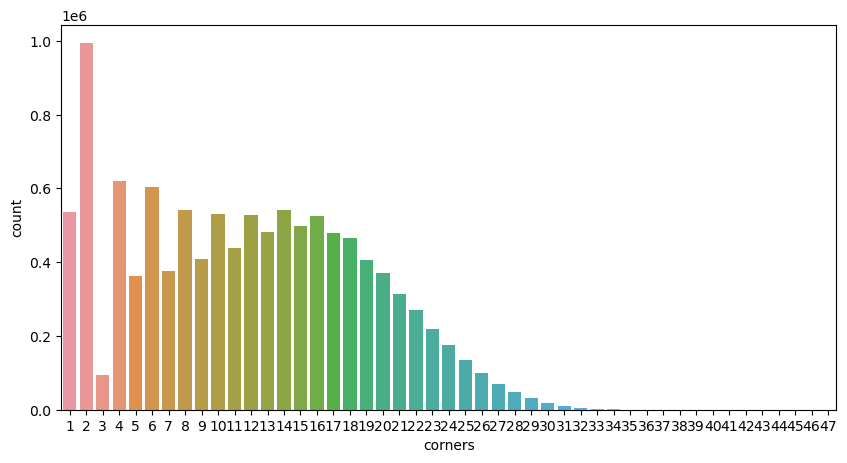

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
sns.countplot(x=Dfcontour['corners'])
plt.show()

### Histogramme des circularités toutes catégories confonfues

C:\Users\shaky\AppData\Local\Temp\ipykernel_11800\2691292899.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Dfcontour['circularity'].replace(np.inf, max_value, inplace=True)
C:\Users\shaky\AppData\Local\Temp\ipykernel_11800\2691292899.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

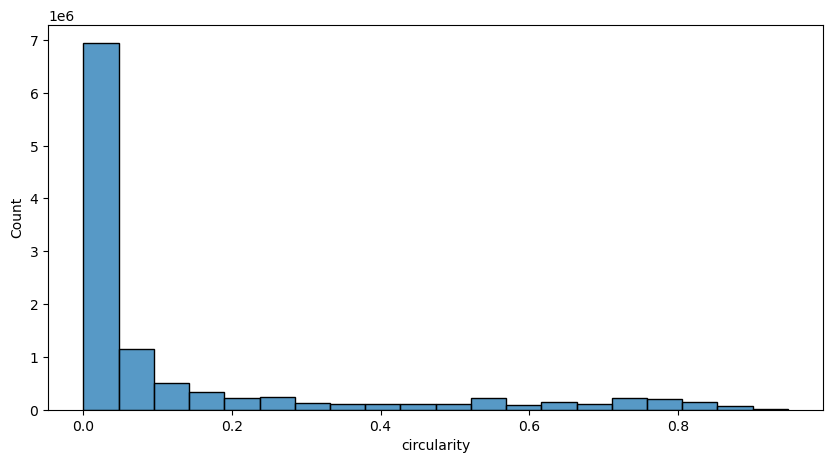

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

# Calculer le maximum et le minimum réels de la colonne, en excluant les infinis
max_value = Dfcontour['circularity'].replace([np.inf, -np.inf], np.nan).max()
min_value = Dfcontour['circularity'].replace([np.inf, -np.inf], np.nan).min()

# Remplacer np.inf par le max réel et -np.inf par le min réel
Dfcontour['circularity'].replace(np.inf, max_value, inplace=True)
Dfcontour['circularity'].replace(-np.inf, min_value, inplace=True)

# Tracer votre histogramme
plt.figure(figsize=(10,5))
sns.histplot(x=Dfcontour['circularity'], bins=20)
plt.show()

### Histogramme des angles par catégorie
graphique Seaborn

10 livres
40 jeux video pour pc et consoles
50  accesoires jeux video
60 consoles de jeux video
1140 produits derives “geeks” et figurines
1160 cartes collectionables
1180 figurines collectionables pour jeux de societe
1280 jouets, peluches, poupees
1281 jeux de societe/cartes
1300 Petites voitures (jouets) et maquettes
1301 accesoires pour petis enfants/bebes et mobilier de jeu (flechettes, billard, babyfoot)
1302 jeux d'exterieur
1320 sacs pour femmes et accesore petite enfance
1560 Mobilier et produits decoration/rangement pour la maison
1920 linge de maison (cousins, rideaux, serviettes, nappes, draps)
1940 nouriture (cafes,infusions,conserves, epices,etc)
2060 lampes et accesoires decoration pour maison
2220 accesoires mascots/pets
2280 magazines
2403 livres et bds
2462 consoles de jeux video et jeux videos
2522 produits de papeterie et rangement bureau
2582 mobilier d'exterieur et accesoires (parasols,pots,tentes,etc)
2583 accesoires de piscine
2585 outillage et accesoires pour j

<Figure size 1000x500 with 0 Axes>

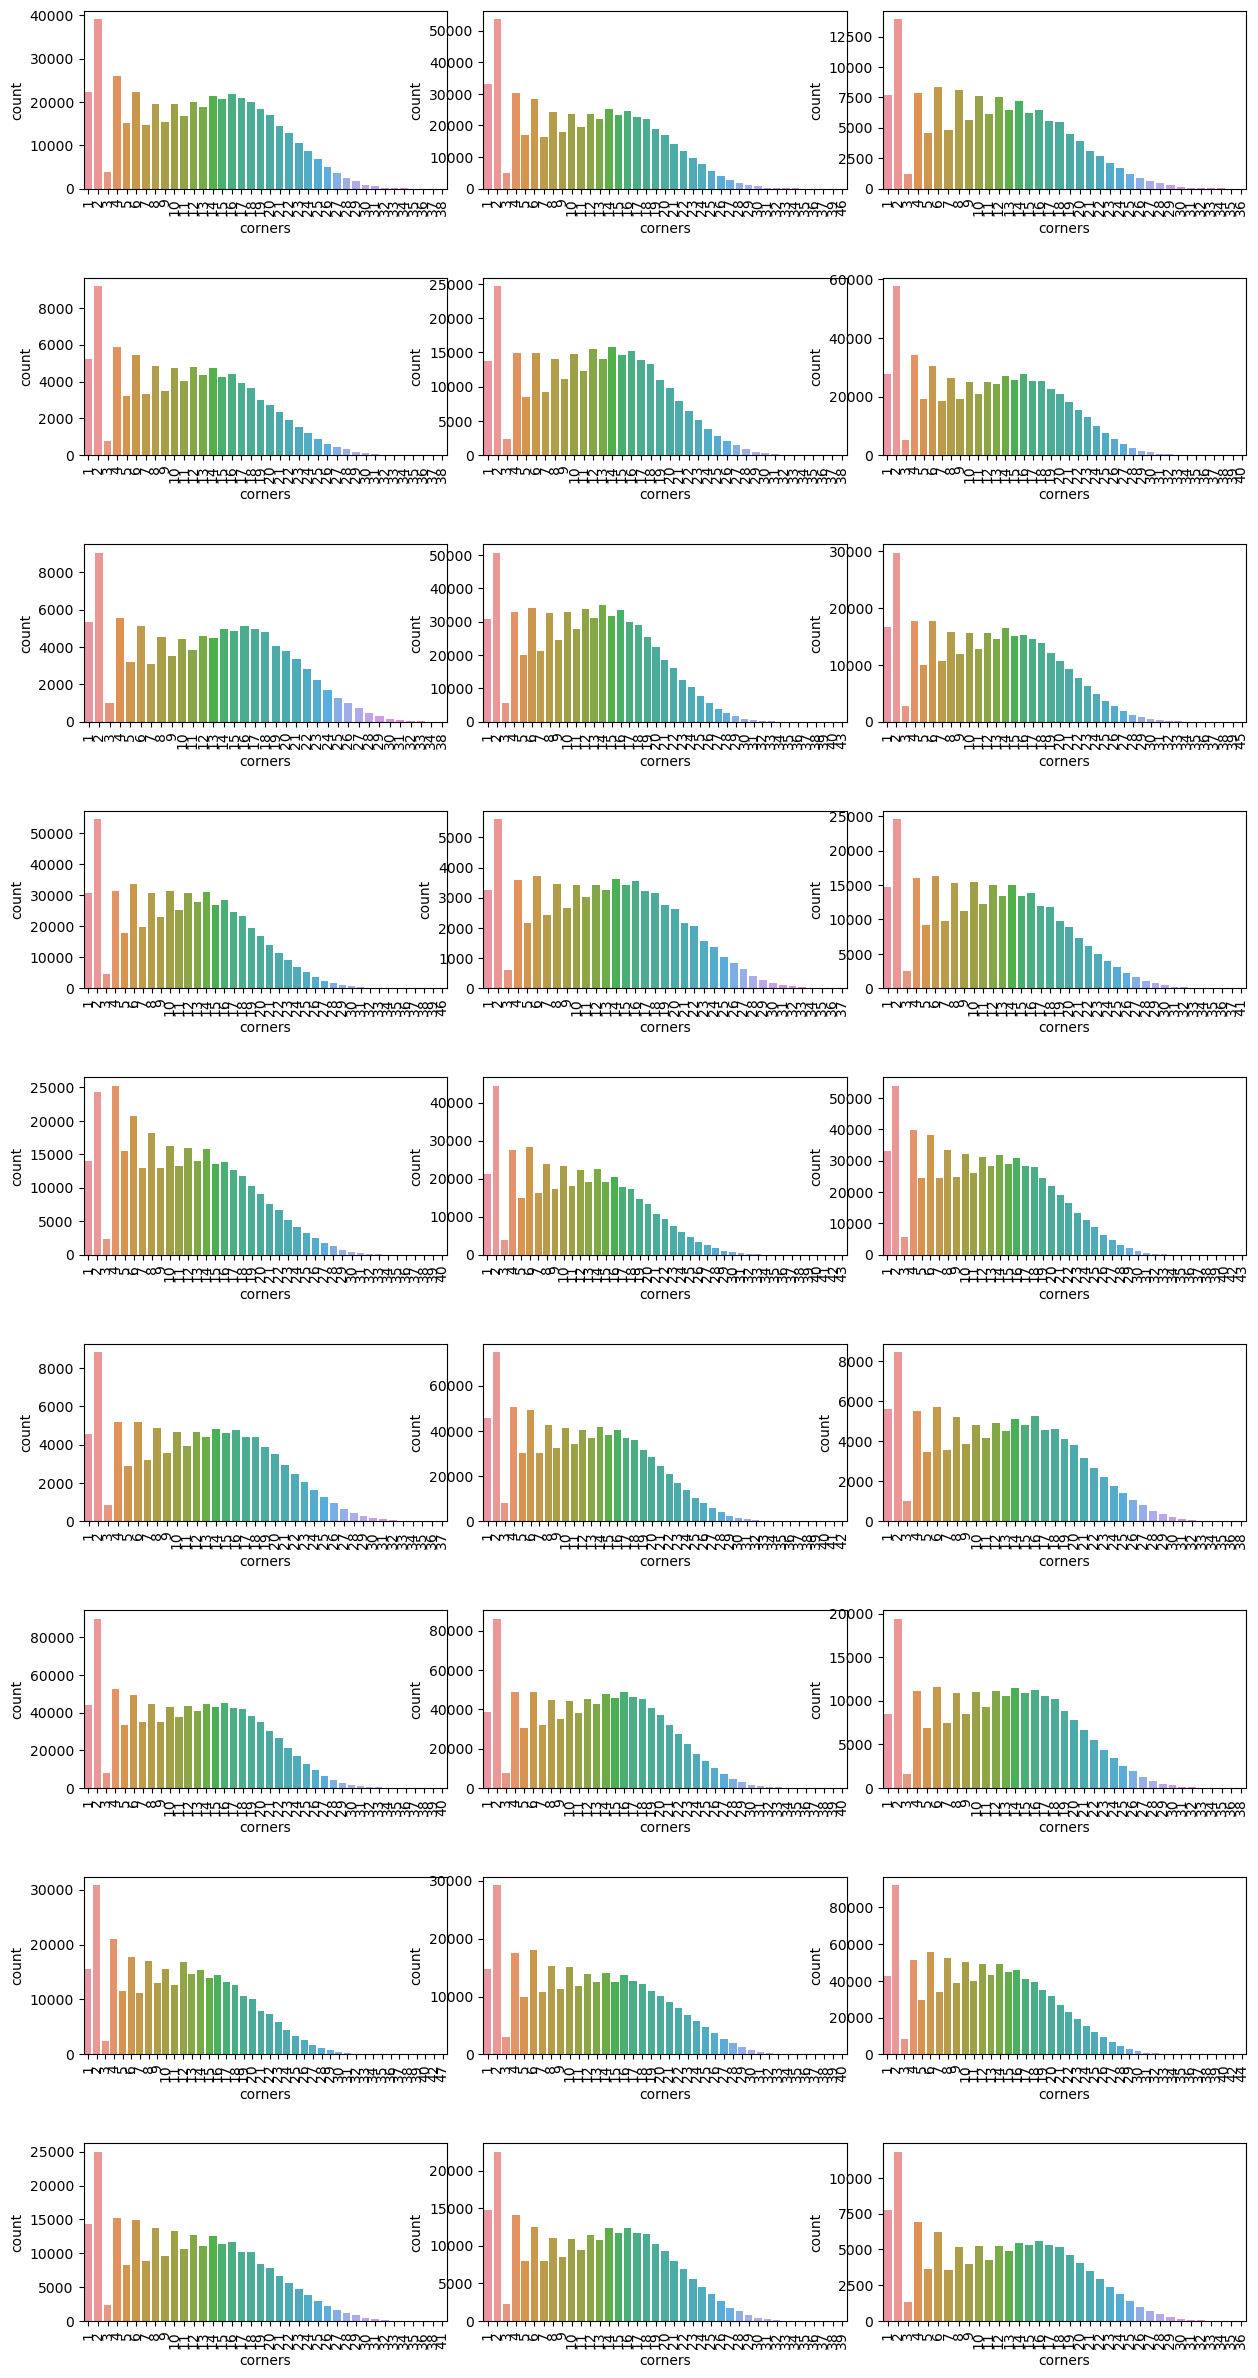

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
fig, axs = plt.subplots(9, 3, figsize=(15,30))
for c,ax in zip(cat,axs.flat):
    print(c,catdict[c])
    sns.countplot(x=Dfcontour[Dfcontour['prdtypecode']==c]['corners'],ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.subplots_adjust( wspace=0.1,hspace=0.5)    
plt.show()

### Histogramme des angles par catégorie
graphique Matplotlib

10 livres


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1000x500 with 0 Axes>

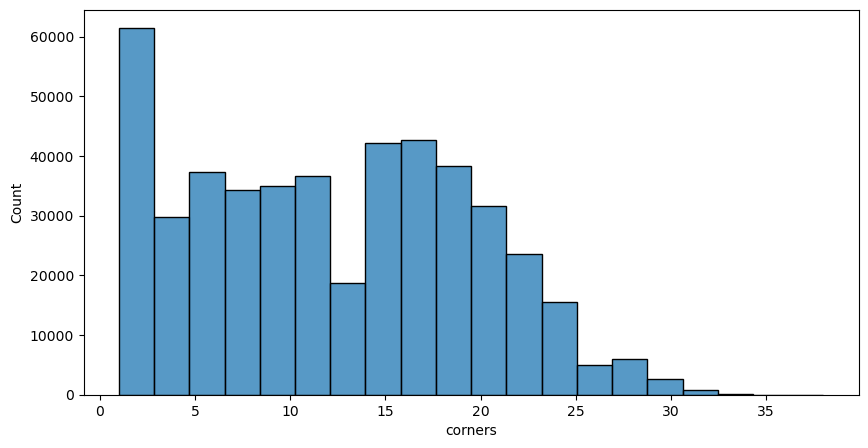

40 jeux video pour pc et consoles


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


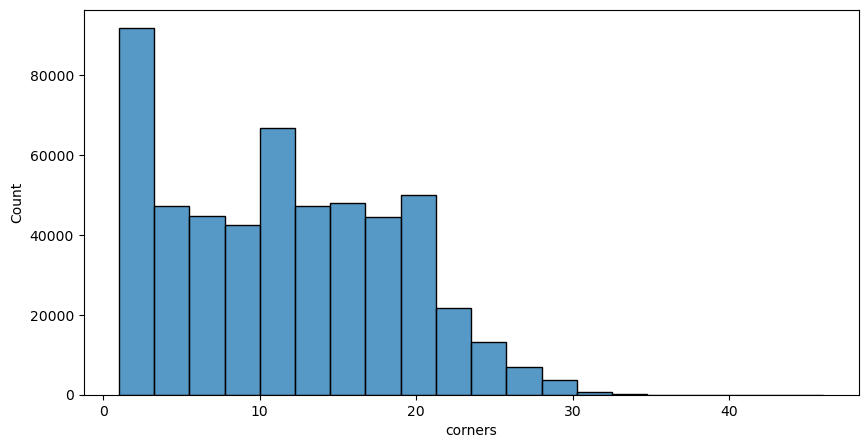

C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


50  accesoires jeux video


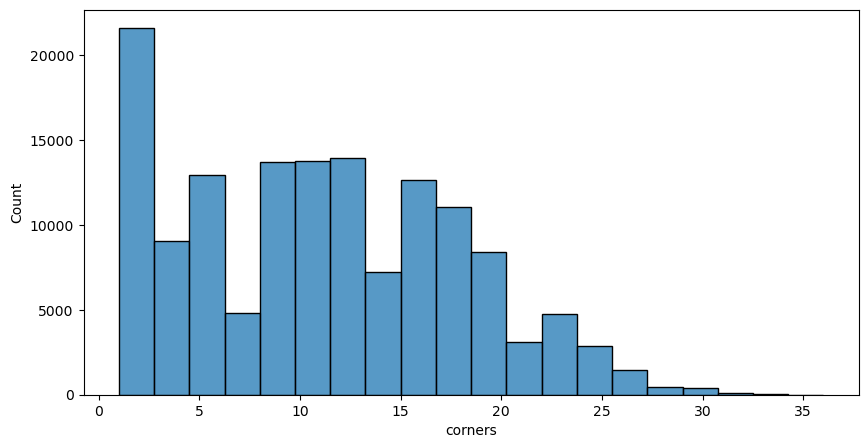

60 consoles de jeux video


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


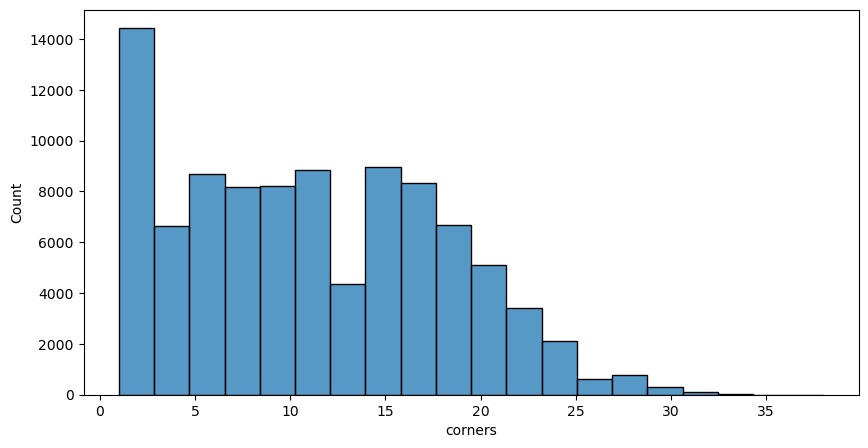

1140 produits derives “geeks” et figurines


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


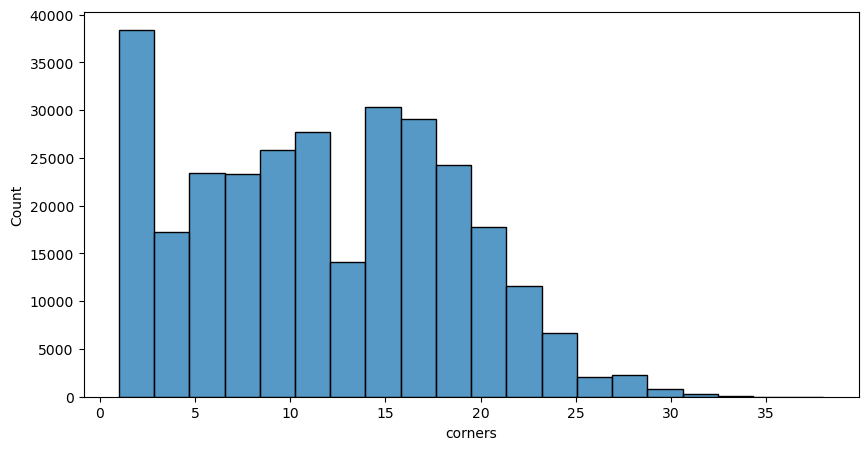

1160 cartes collectionables


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


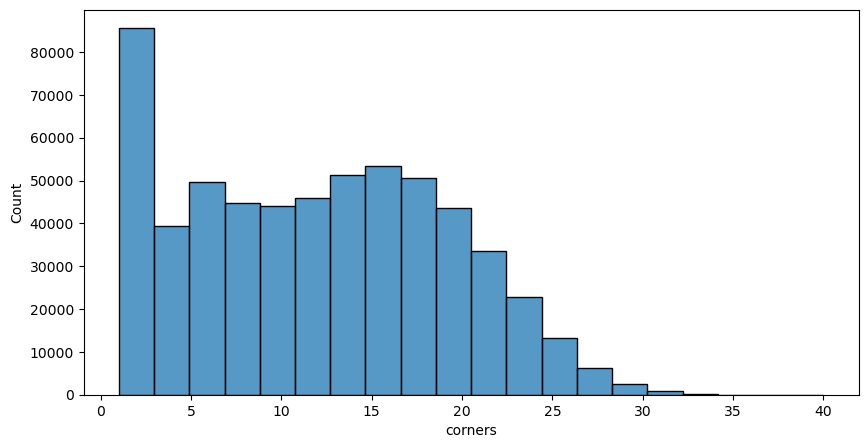

C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


1180 figurines collectionables pour jeux de societe


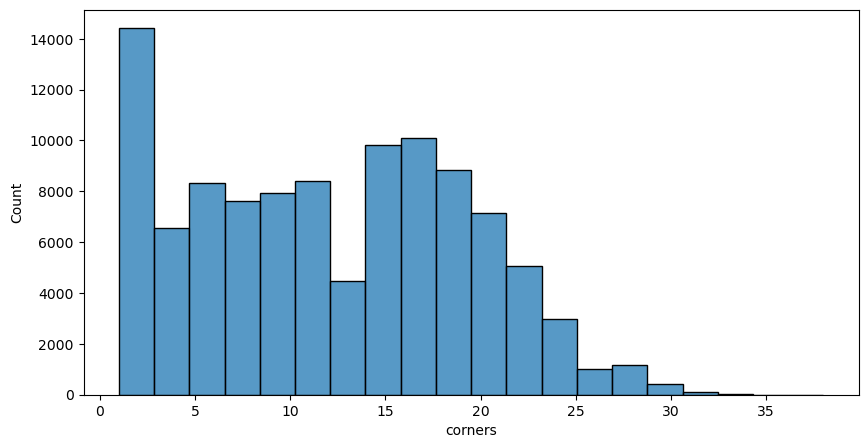

1280 jouets, peluches, poupees


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


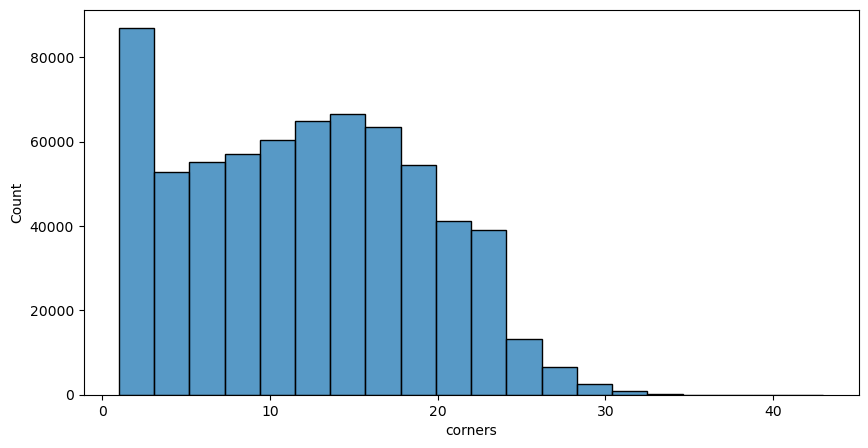

1281 jeux de societe/cartes


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


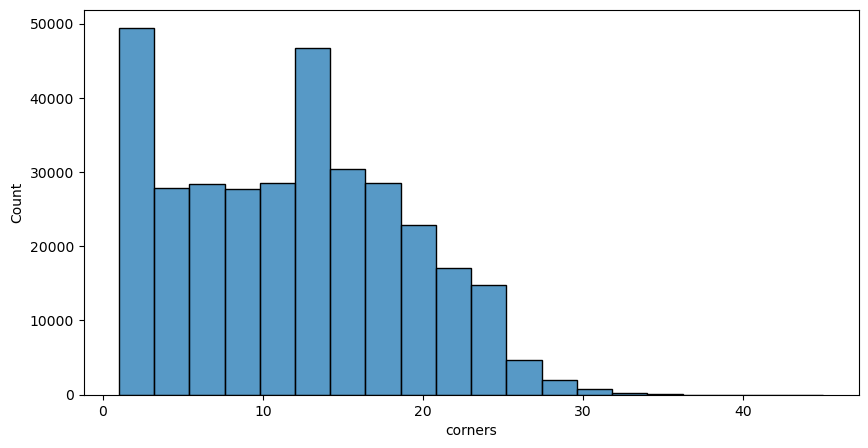

1300 Petites voitures (jouets) et maquettes


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


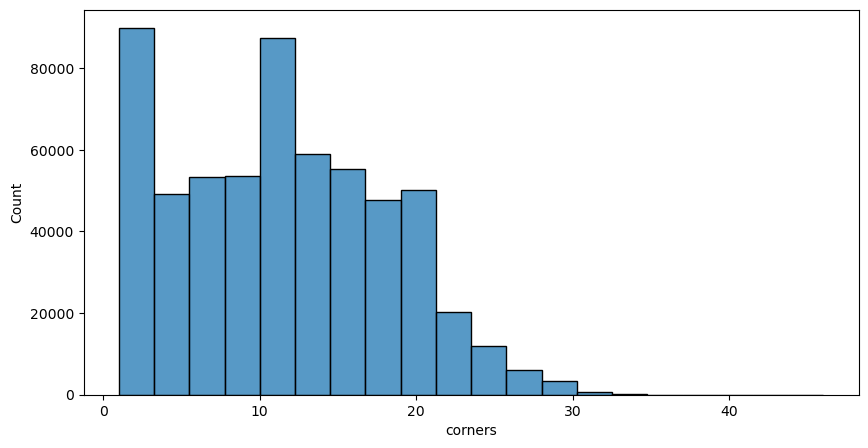

C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


1301 accesoires pour petis enfants/bebes et mobilier de jeu (flechettes, billard, babyfoot)


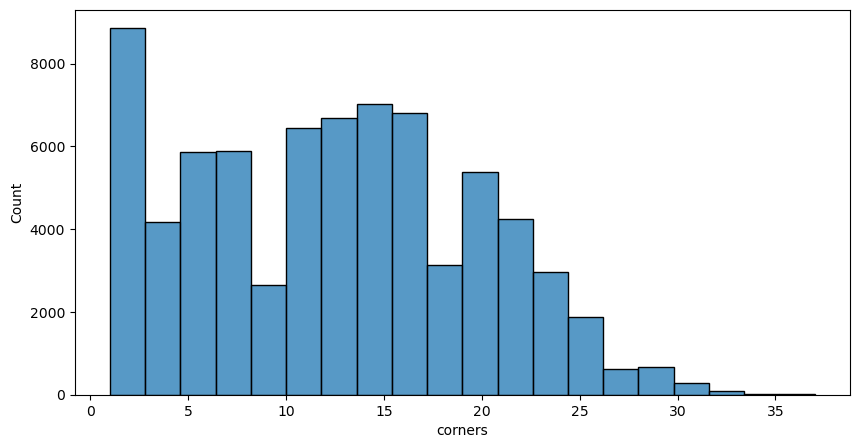

1302 jeux d'exterieur


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


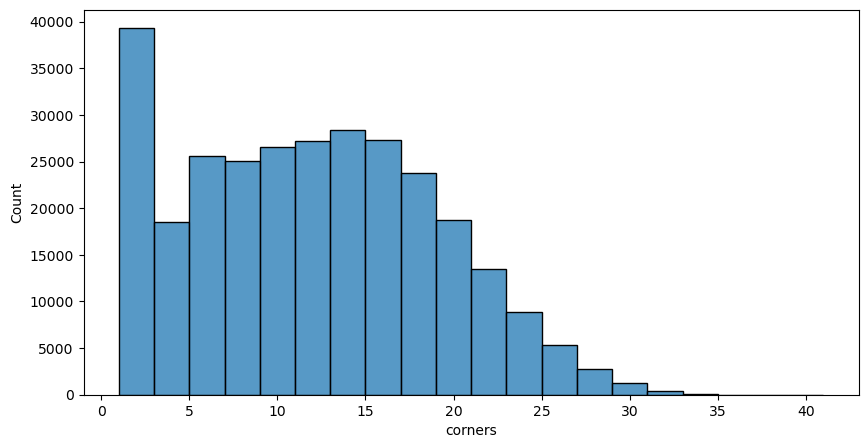

1320 sacs pour femmes et accesore petite enfance


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


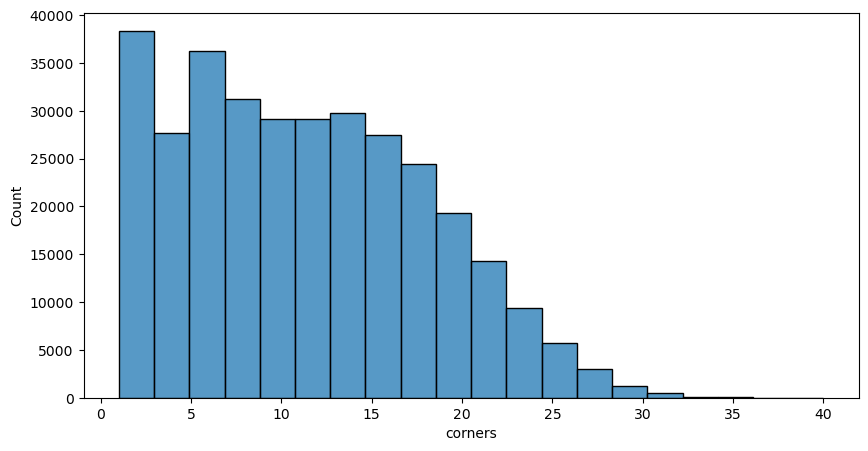

1560 Mobilier et produits decoration/rangement pour la maison


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


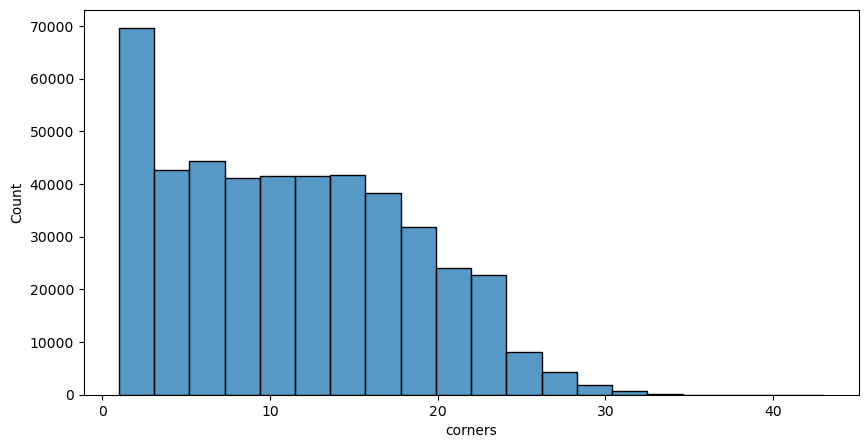

1920 linge de maison (cousins, rideaux, serviettes, nappes, draps)


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


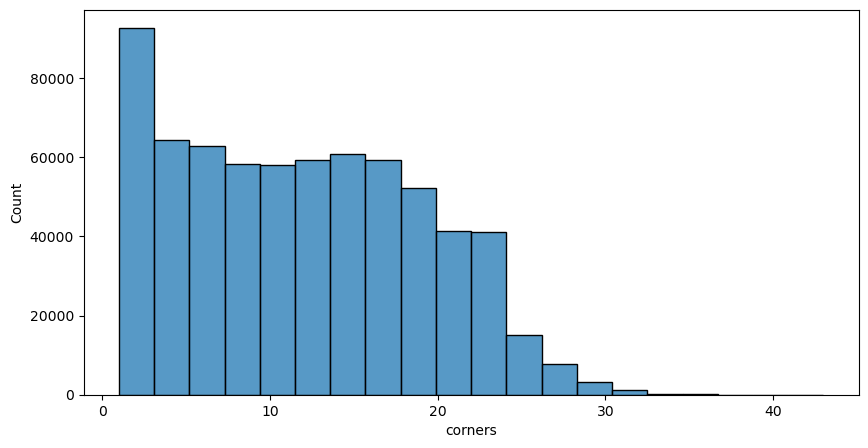

C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


1940 nouriture (cafes,infusions,conserves, epices,etc)


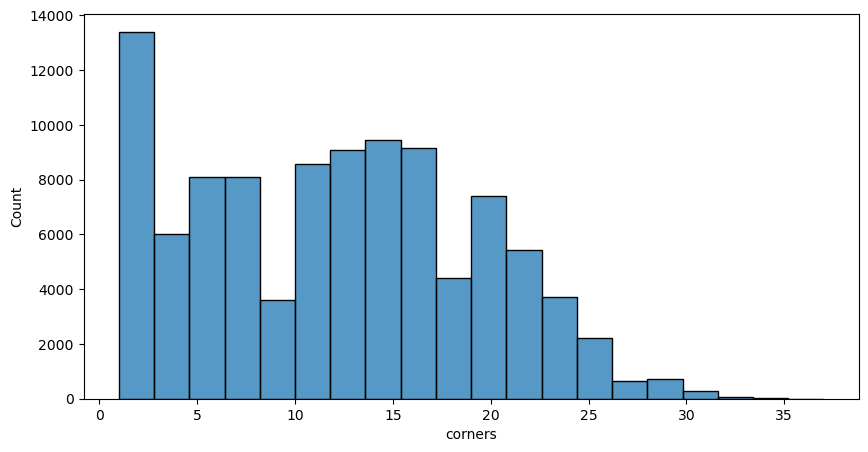

2060 lampes et accesoires decoration pour maison


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


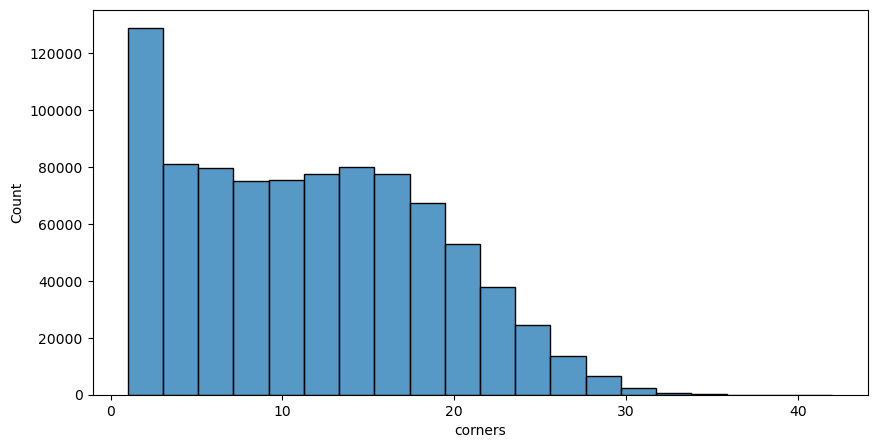

C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


2220 accesoires mascots/pets


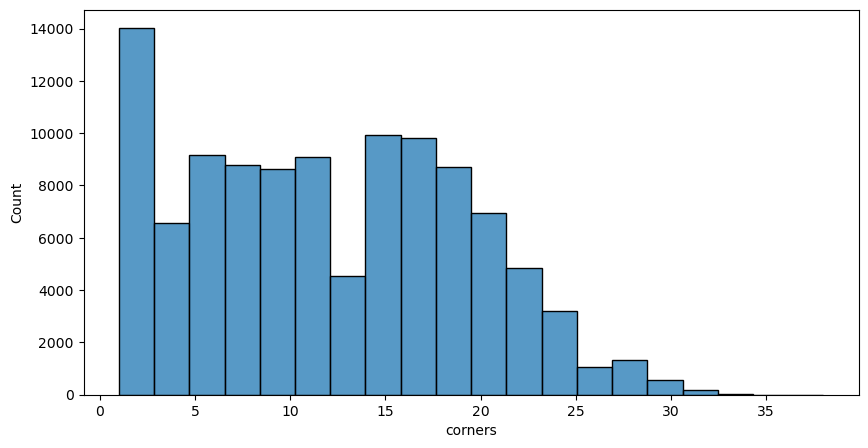

2280 magazines


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


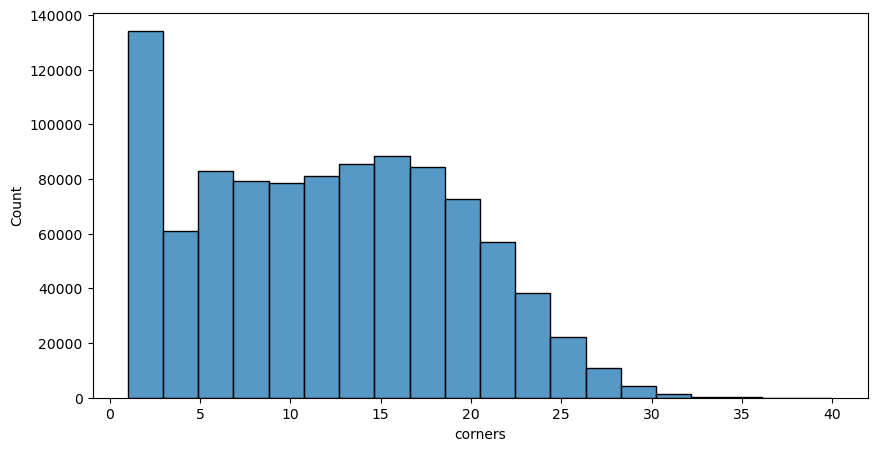

2403 livres et bds


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


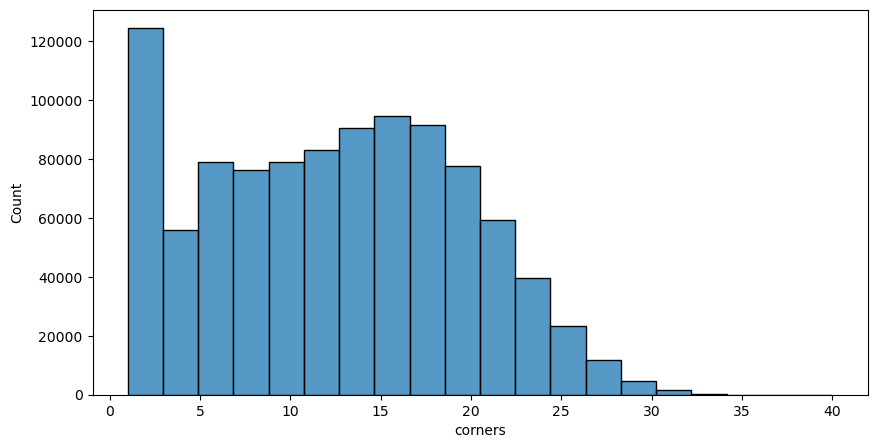

2462 consoles de jeux video et jeux videos


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


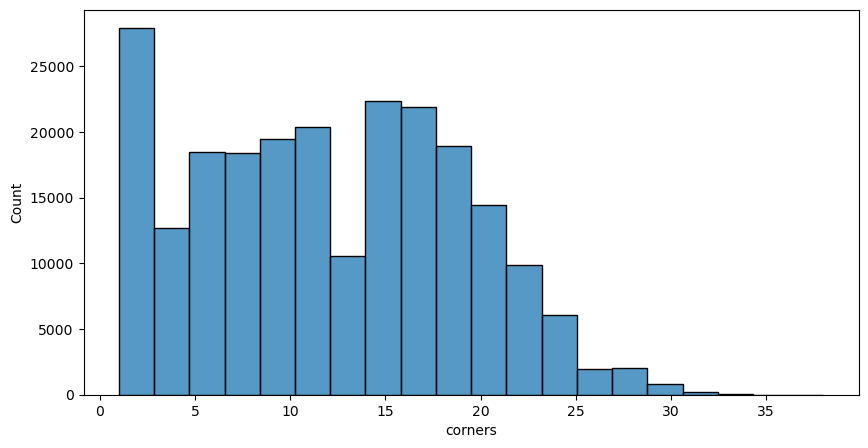

2522 produits de papeterie et rangement bureau


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


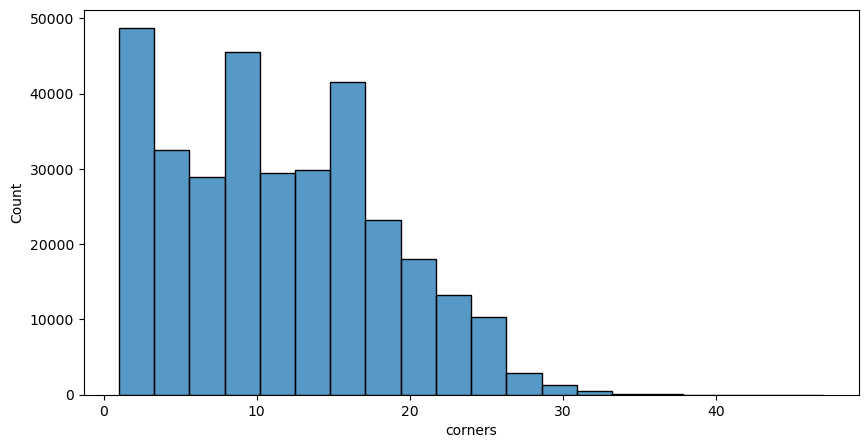

2582 mobilier d'exterieur et accesoires (parasols,pots,tentes,etc)


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


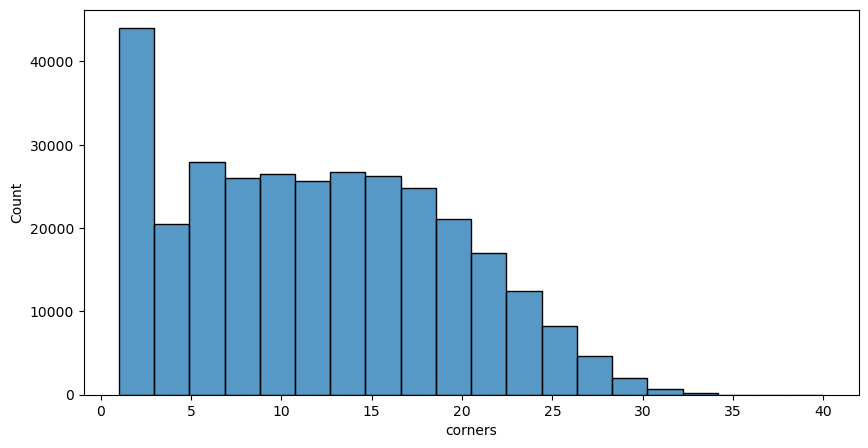

2583 accesoires de piscine


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


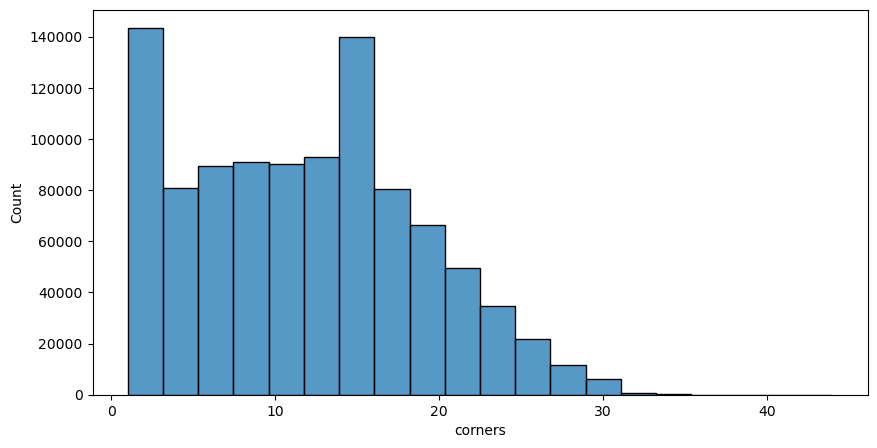

2585 outillage et accesoires pour jardinage


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


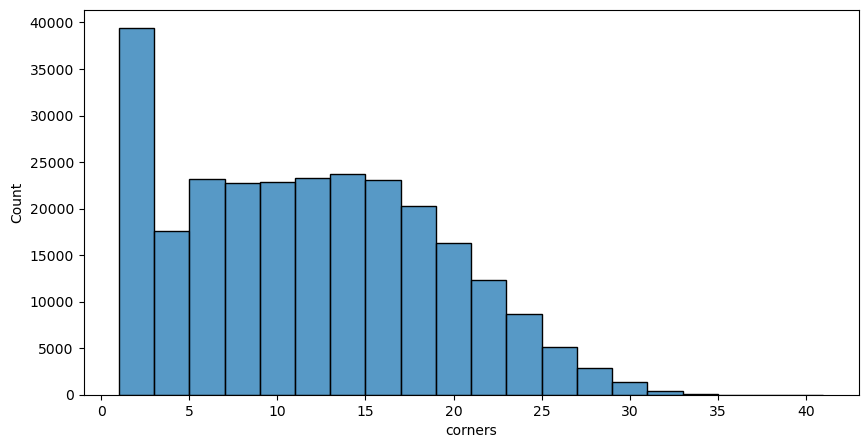

2705 bds et livres


C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


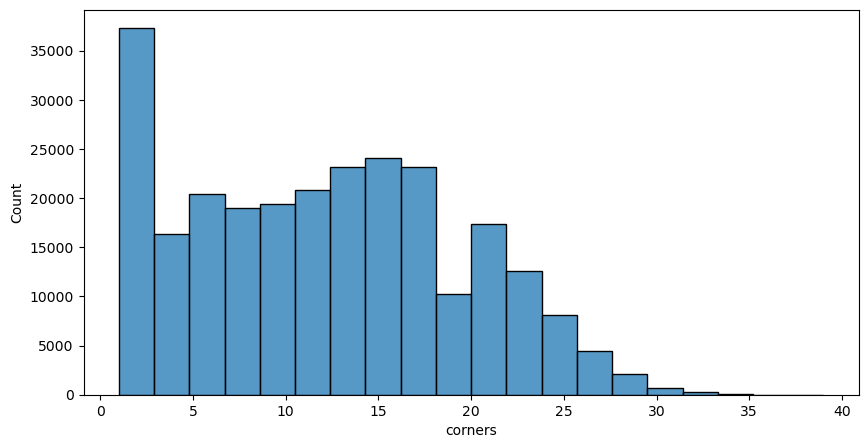

C:\Users\shaky\AppData\Local\anaconda3\envs\tfdml_cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


2905 Jeu En téléchargement


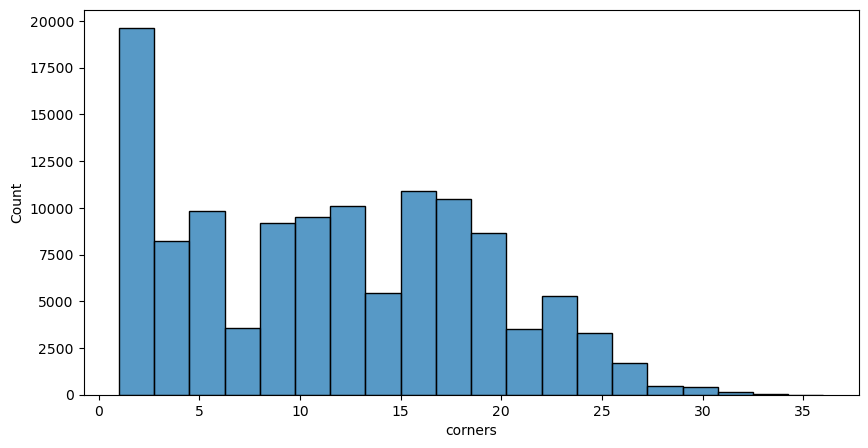

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
for c in cat:
    print(c,catdict[c])
    plt.figure(figsize=(10,5))
    sns.histplot(x=Dfcontour[Dfcontour['prdtypecode']==c]['corners'],bins=20)
    plt.show()